In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from scipy.linalg import svd
from scipy.interpolate import UnivariateSpline

In [2]:
pulses = pd.read_excel('pulses.xlsx', dtype=np.float)

timecol = 'Time (s)'

largest_freq = 'f = 2.0 THz'

# extract time colums and delet it
times = pulses[timecol].to_numpy()
pulses.drop(columns=[timecol], inplace=True)

# scale the fileds to maximum
field_ampl = pulses.abs().max().max()
pulses /= field_ampl

pulses.columns

Index(['f=0.4 THz', 'f = 0.5 THz', 'f = 0.6 THz', 'f = 0.7 THz', 'f = 0.8 THz',
       'f = 0.9 THz', 'f = 1.0 THz', 'f = 1.1 THz', 'f = 1.2 THz',
       'f = 2.0 THz'],
      dtype='object')

In [3]:
# using spline interpolation to add more time points
t_old = np.linspace(0, 1, times.size)
t_new = np.linspace(0, 1, 10 * times.size)

# redefining dataframe
pulses = pd.DataFrame({
    colname: UnivariateSpline(t_old, pulses[colname], s=0)(t_new) 
    for colname in pulses.columns
})

# redefining time array 
times = np.linspace(times[0], times[-1], len(pulses))

In [4]:
def plot_pulses(df):
    """
    Plot pulses saved in DataFrame dt
    """
    for colname in df.columns:        
        
        plt.plot(times, df[colname], label=colname)

    plt.ylabel('Nomrlized electric field')
    plt.xlabel(timecol)
    plt.legend()
    plt.show()

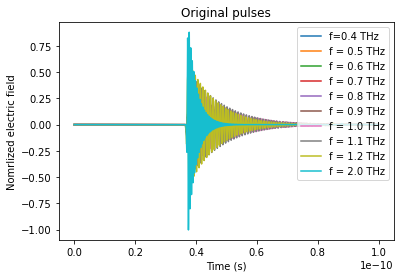

In [5]:
plt.title('Original pulses')
plot_pulses(pulses)

In [6]:
# For the highest frequency field, find the position (time index) of the largest peak
# and the peak before and after that.

# Define the observational time window to be the period containing the largest peak

largest_peak = np.argmax(pulses[largest_freq].abs())
peaks = find_peaks(pulses[largest_freq].abs())[0]

peak_before_largest = peaks[peaks < largest_peak].max()
peak_after_largest = peaks[peaks > largest_peak].min()

observational_window = peak_after_largest - peak_before_largest

In [7]:
# Temporally shift pulses such that their beaks are aligned

# Additional offset is introduced such that 
# the observational time windows starts at time index 0

add_offset = largest_peak - peak_before_largest

for colname in pulses.columns:
    filed = pulses[colname]
    pulses[colname] = np.roll(filed, -np.argmax(filed.abs()) + add_offset)

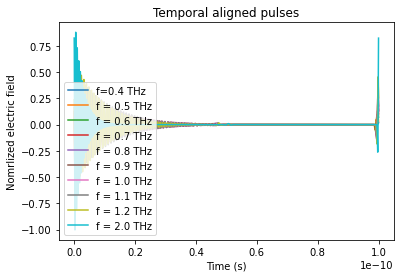

In [8]:
plt.title('Temporal aligned pulses')
plot_pulses(pulses)

In [9]:
# Finding optimal strategies for generating supperoscilations via SVD
U, sigmas, Vh = svd(pulses[:observational_window], full_matrices=False)

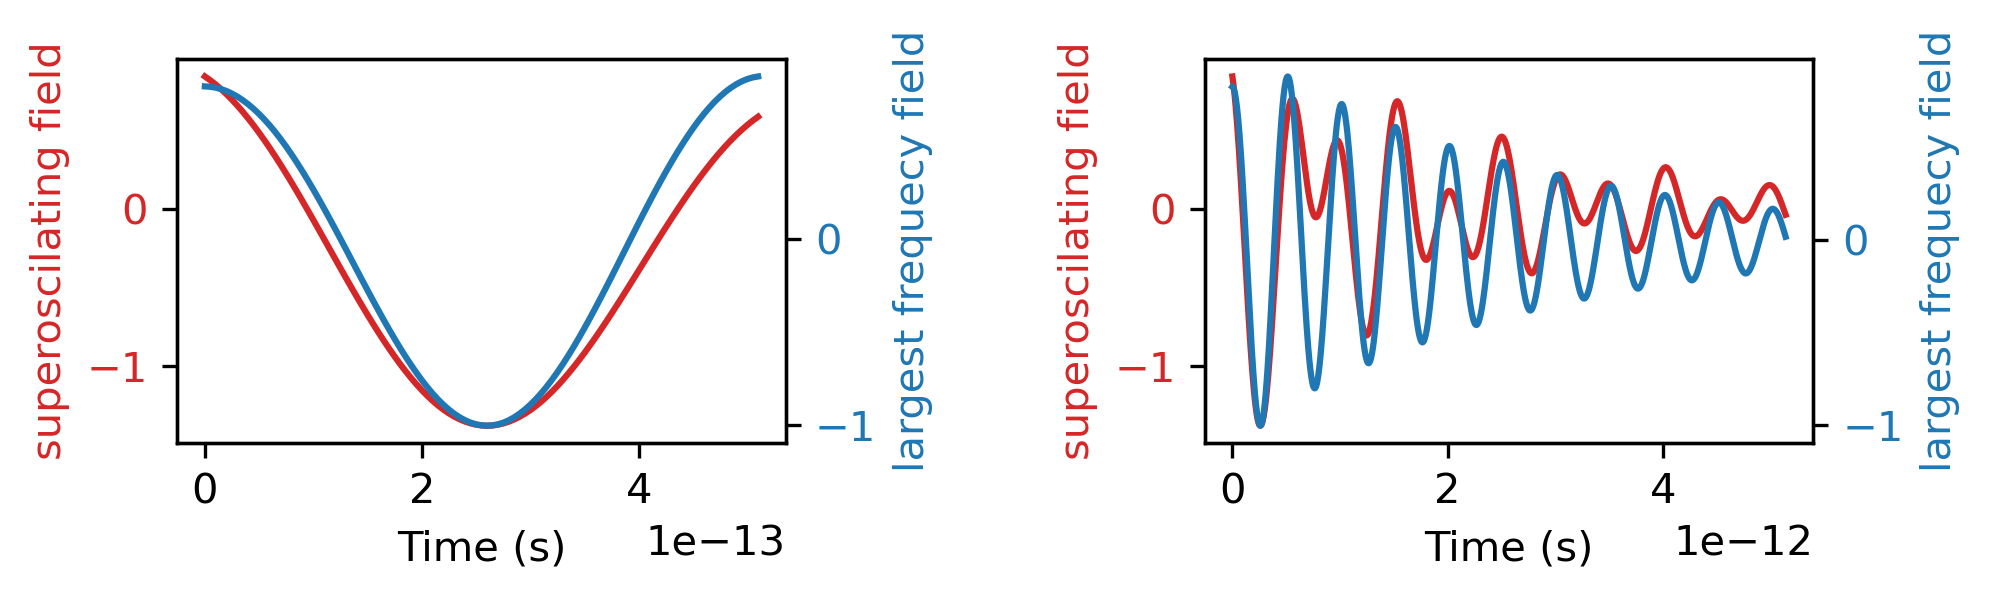

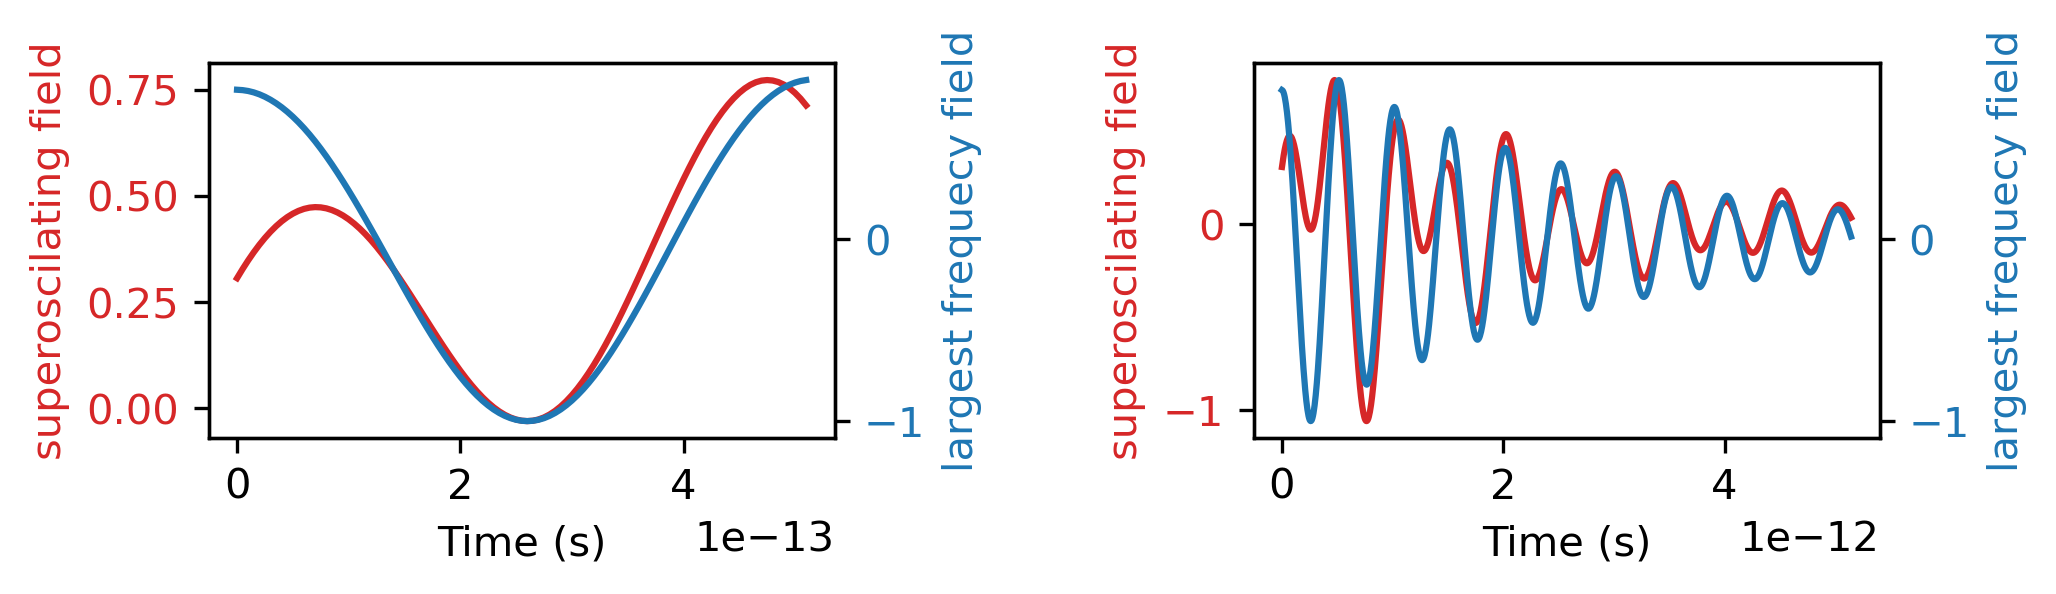

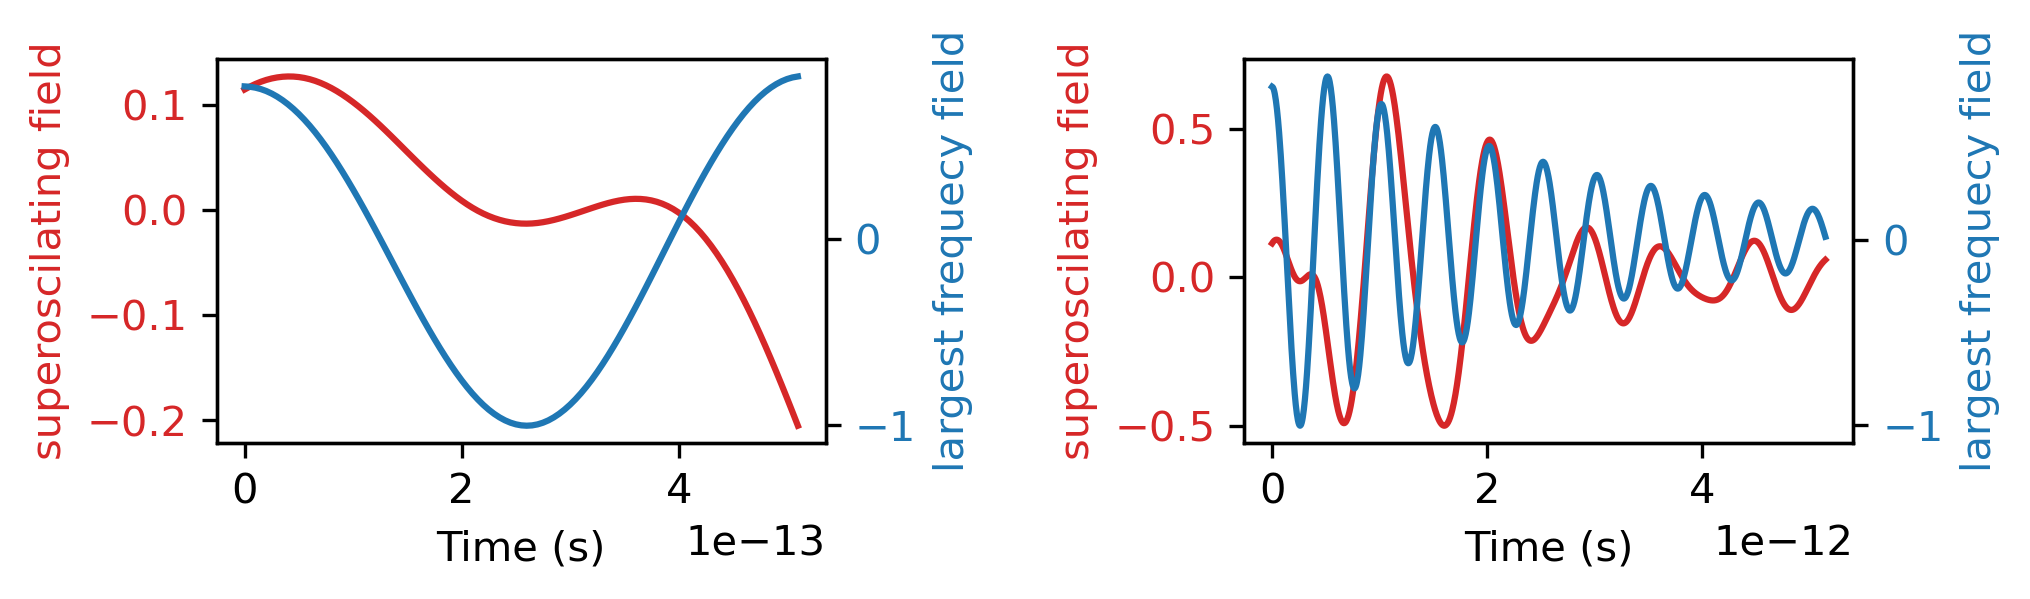

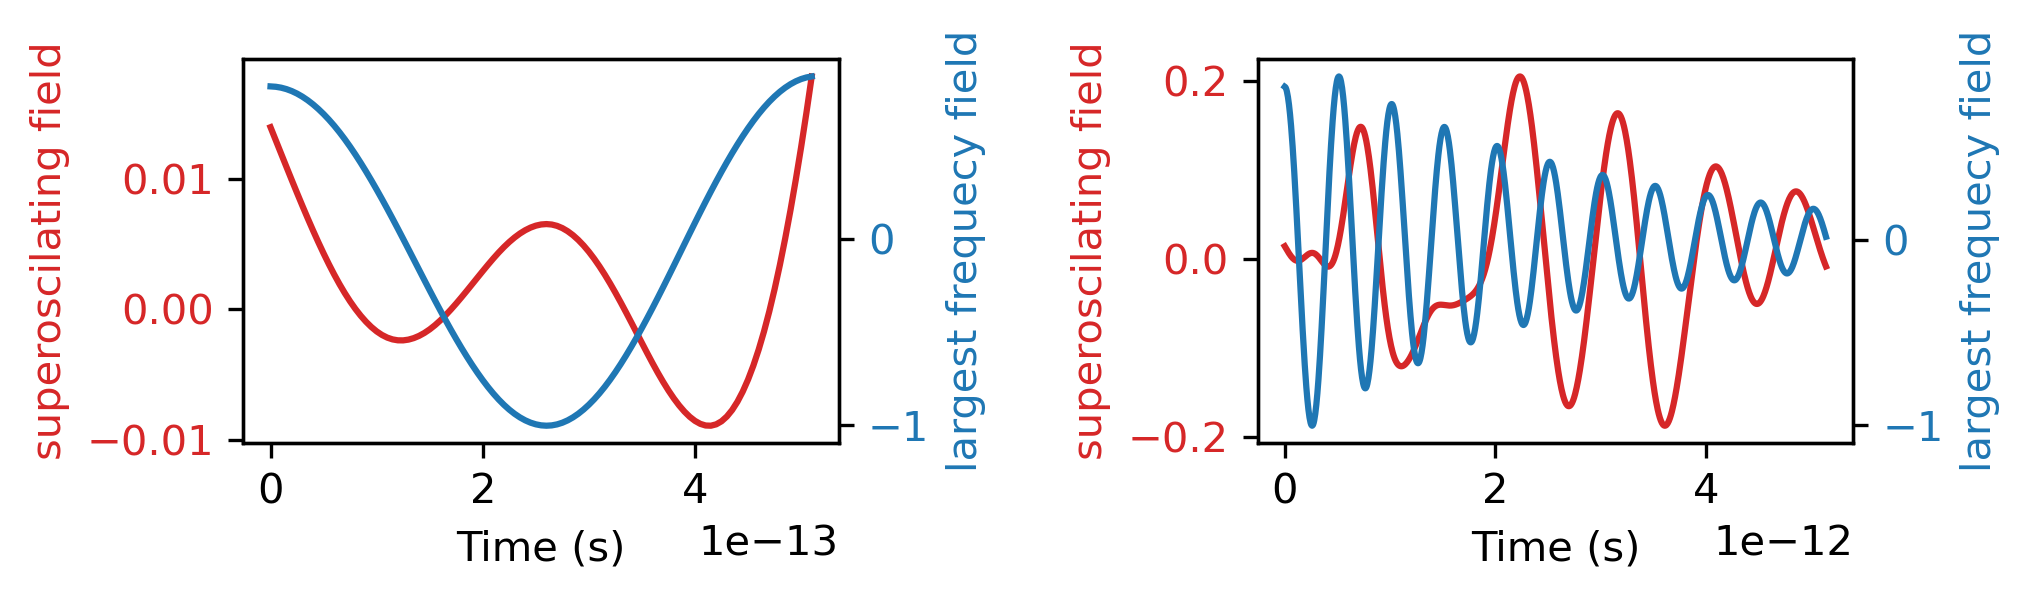

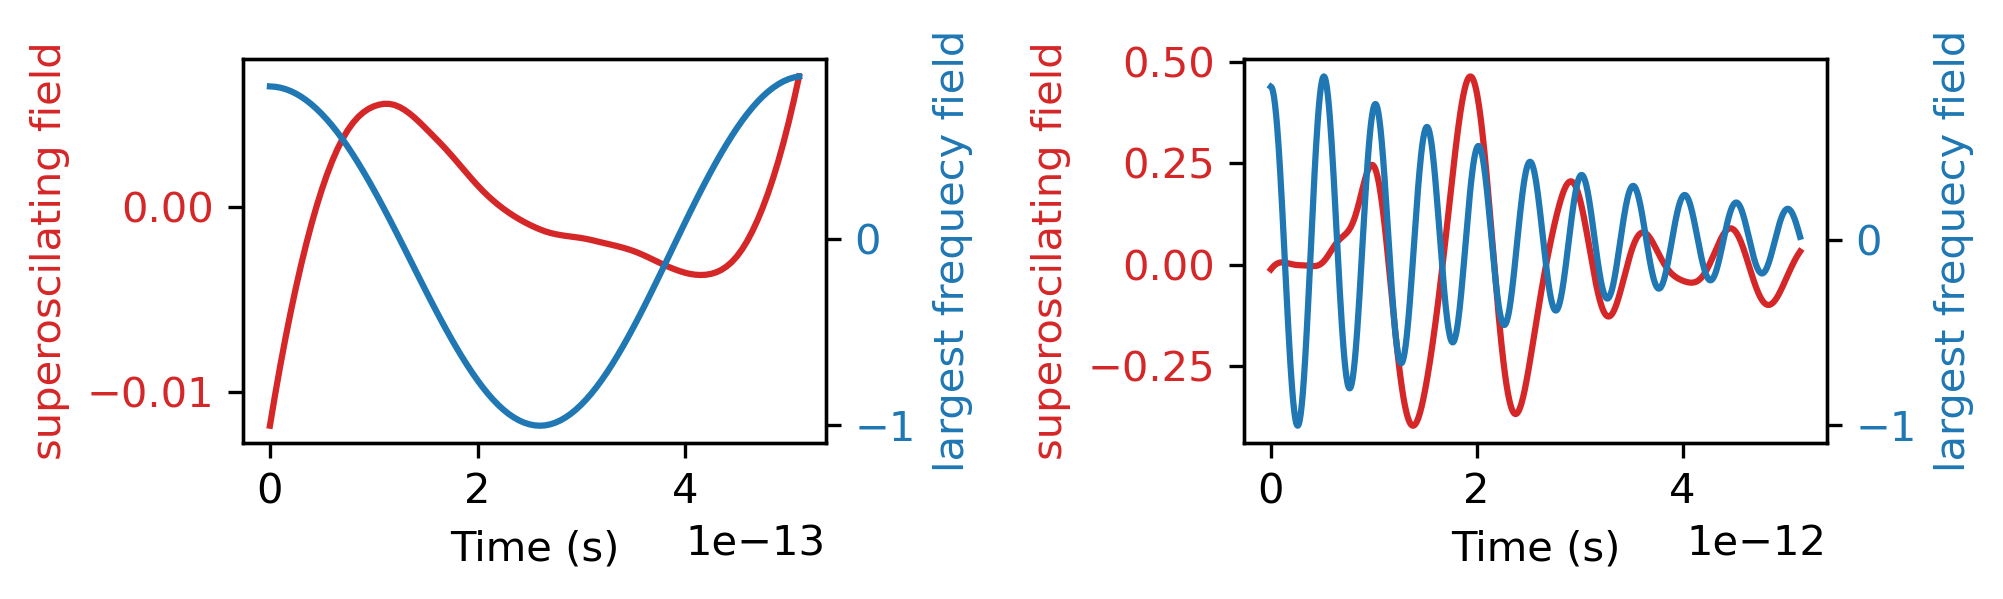

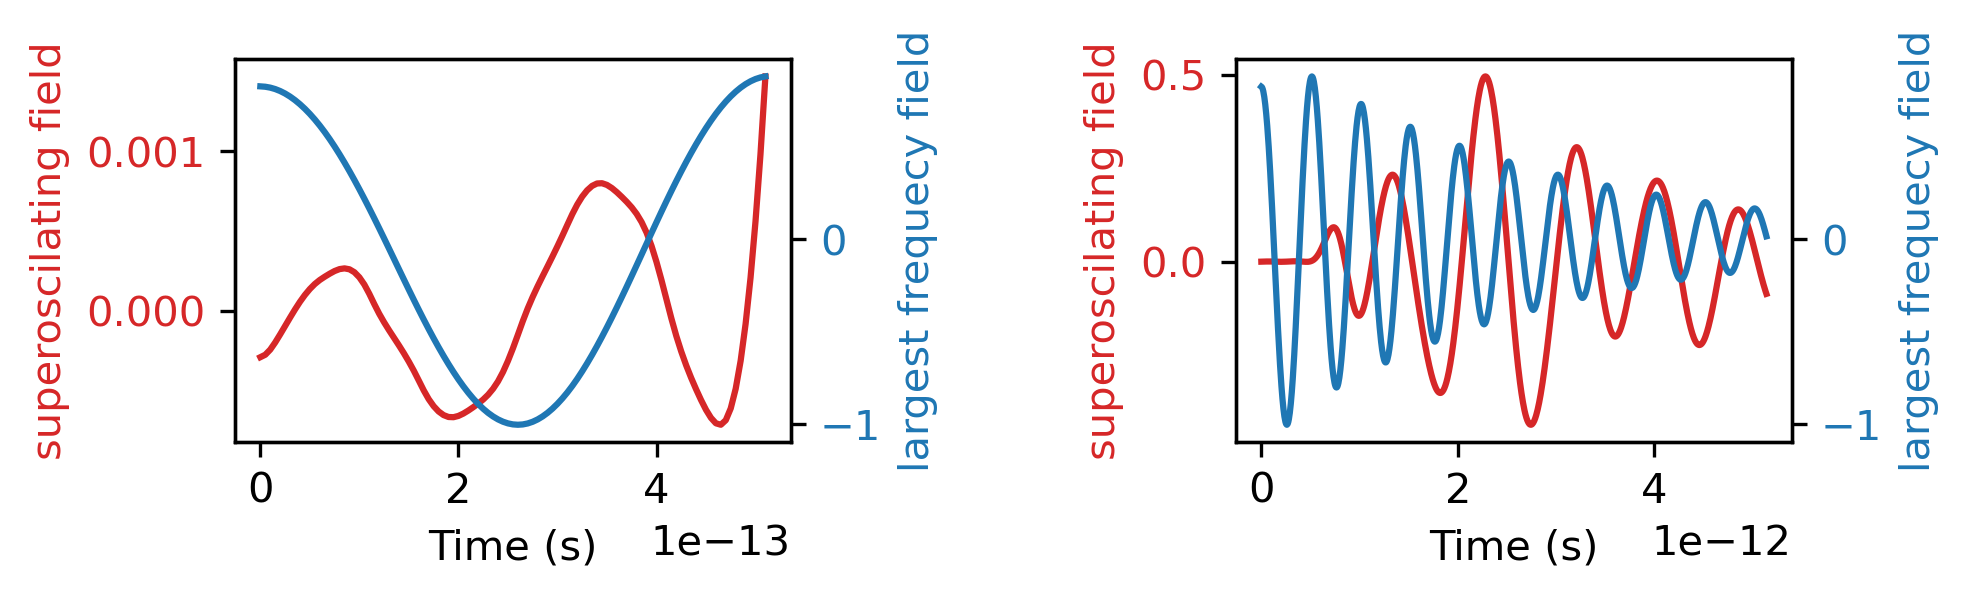

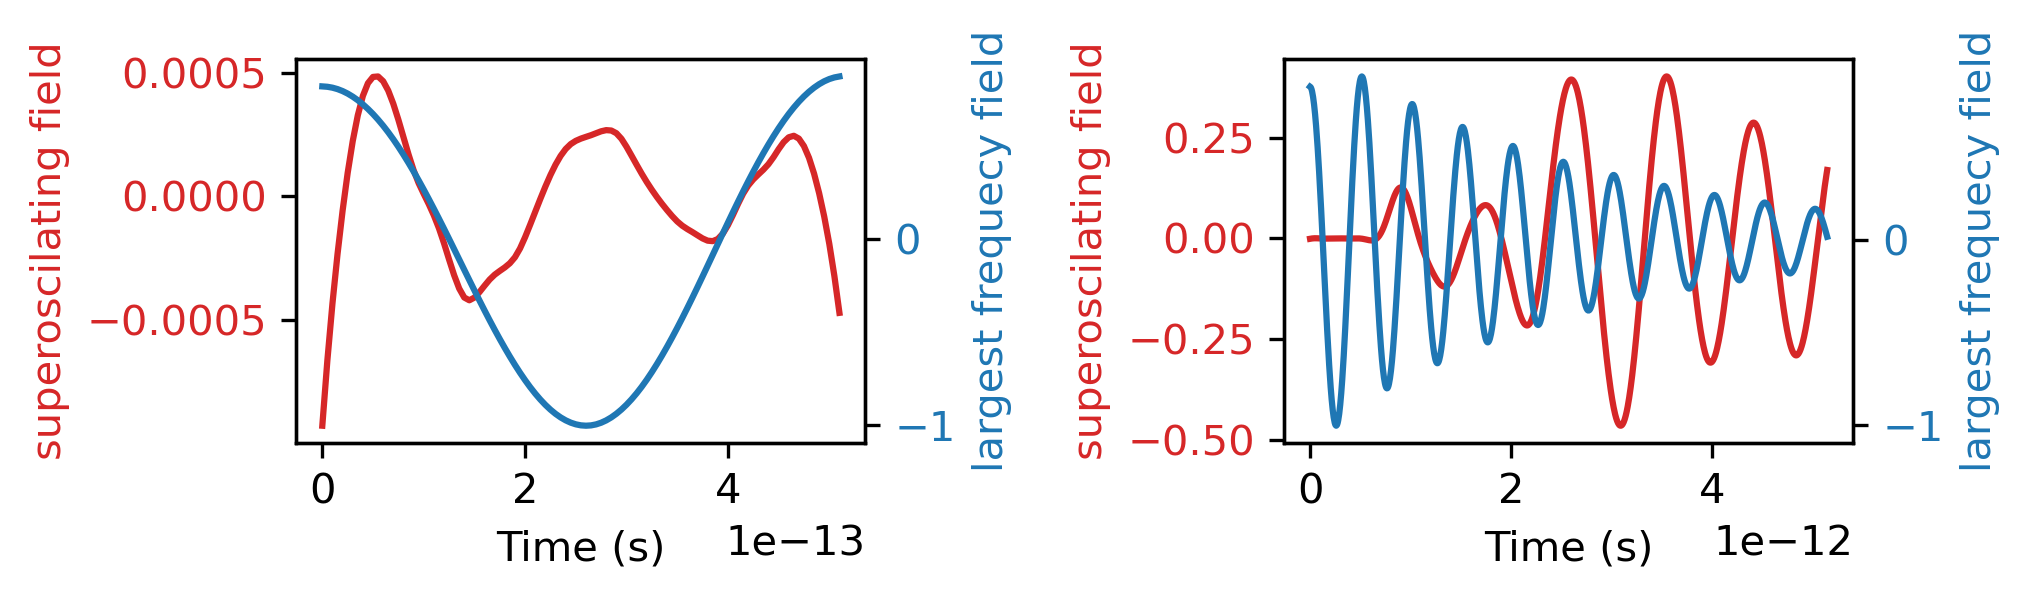

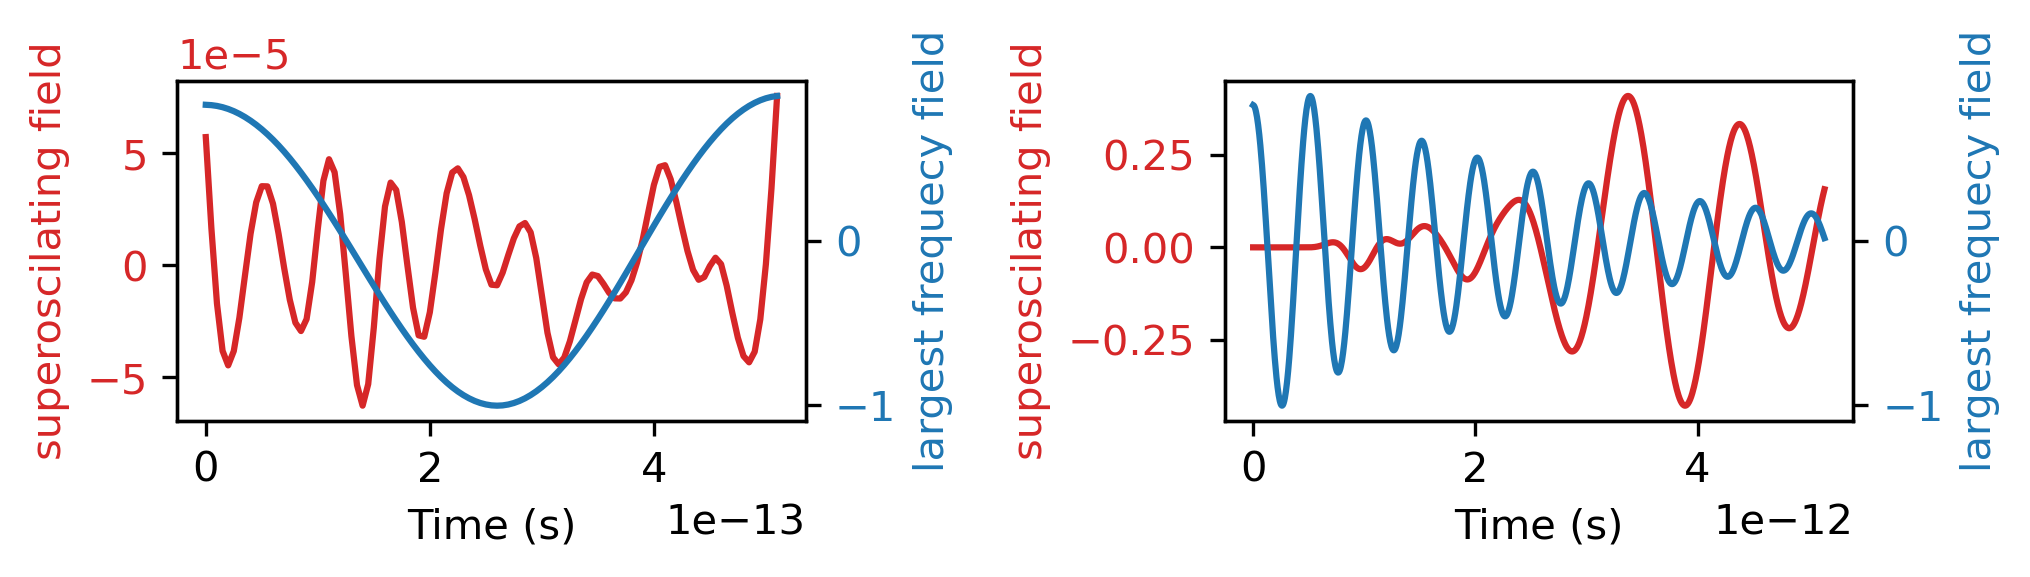

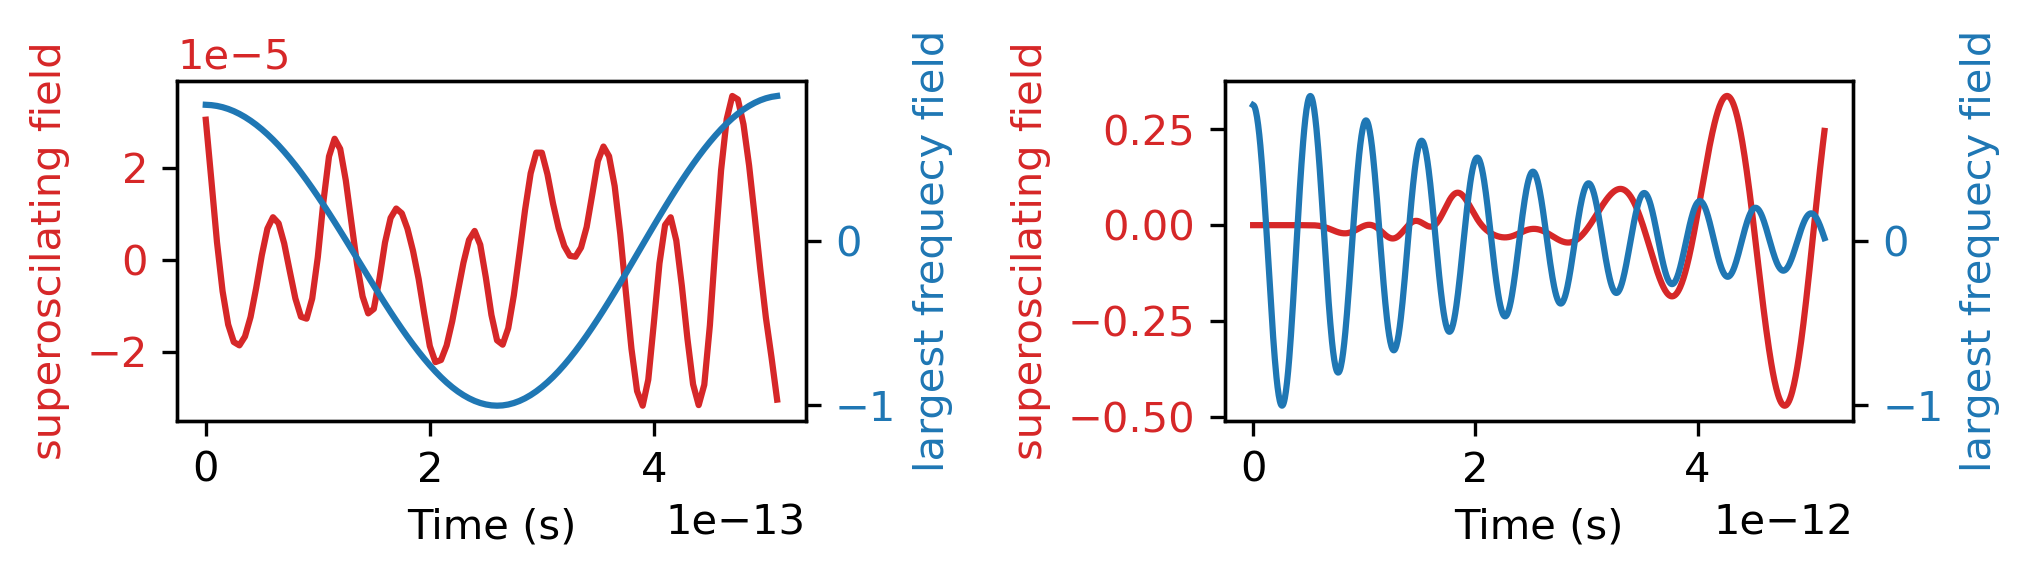

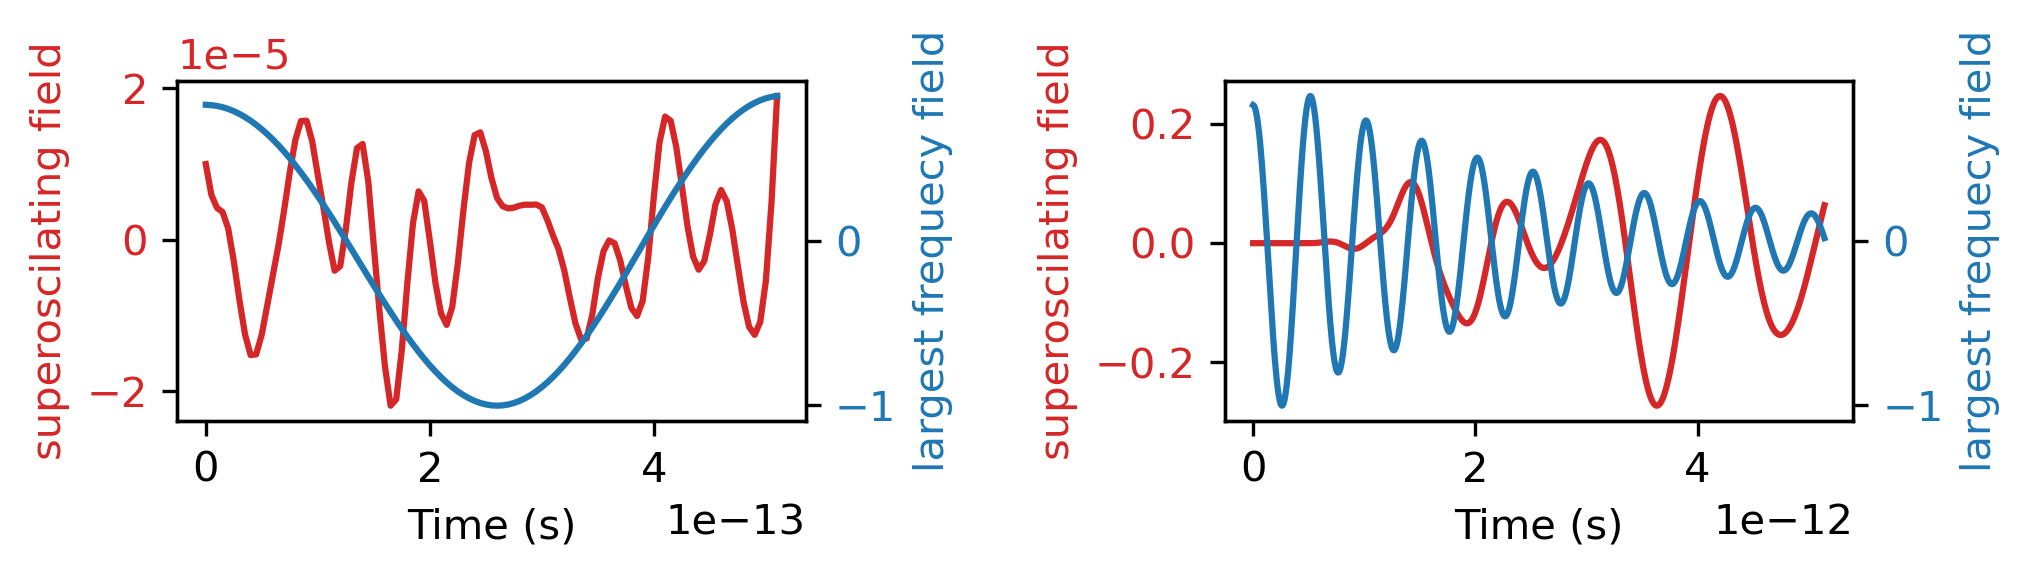

In [10]:
largest_freq_pulse = pulses[largest_freq]


for num, singular_vector in enumerate(Vh):
    
    # get superoscilating fields
    field = pulses @ singular_vector
    
    fig, (ax1, ax1_) = plt.subplots(1, 2, figsize=(7, 2), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('superoscilating field', color=color1)
    ax1.plot(times[:observational_window], field[:observational_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('largest frequecy field', color=color2)
    ax2.plot(times[:observational_window], largest_freq_pulse[:observational_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # 
    larger_window = 10 * observational_window
    
    ax1 = ax1_
    
    ax1.set_ylabel('superoscilating field', color=color1)
    ax1.plot(times[:larger_window], field[:larger_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('largest frequecy field', color=color2)
    ax2.plot(times[:larger_window], largest_freq_pulse[:larger_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.pdf'.format(num))
    
    plt.show()